In [67]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [69]:
batch_size = 64

In [71]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])

In [73]:
train_dataset = datasets.MNIST(root='Users/zhouyuhan/Documents/Code/PythonForAnalysis/Test/DL/dataset/mnist', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = datasets.MNIST(root='Users/zhouyuhan/Documents/Code/PythonForAnalysis/Test/DL/dataset/mnist', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [75]:
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, dim=1)

In [77]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5)

        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)

        self.mp = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(1408, 10) # 1408随后输入 待计算后得出size

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incep1(x)
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incep2(x)
        x = x.view(in_size, -1) # 同1408
        x = self.fc(x) # 同1408
        return x

model = Net()

In [79]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [93]:
acc_list = []
epoch_acc_list = []

In [95]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            acc_list.append(100*correct / total)

        epoch_acc = 100 * correct / total
        print('Accuracy on test set: %d %% [%d/%d]' % (100 * correct / total, correct, total))

        epoch_acc_list.append(epoch_acc)

In [97]:
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()

[1,   300] loss: 0.034
[1,   600] loss: 0.031
[1,   900] loss: 0.031
Accuracy on test set: 98 % [9888/10000]
[2,   300] loss: 0.026
[2,   600] loss: 0.033
[2,   900] loss: 0.031
Accuracy on test set: 98 % [9890/10000]
[3,   300] loss: 0.025
[3,   600] loss: 0.029
[3,   900] loss: 0.030
Accuracy on test set: 98 % [9881/10000]
[4,   300] loss: 0.025
[4,   600] loss: 0.024
[4,   900] loss: 0.030
Accuracy on test set: 98 % [9875/10000]
[5,   300] loss: 0.025
[5,   600] loss: 0.022
[5,   900] loss: 0.025
Accuracy on test set: 98 % [9864/10000]
[6,   300] loss: 0.023
[6,   600] loss: 0.022
[6,   900] loss: 0.026
Accuracy on test set: 98 % [9897/10000]
[7,   300] loss: 0.020
[7,   600] loss: 0.025
[7,   900] loss: 0.022
Accuracy on test set: 98 % [9895/10000]
[8,   300] loss: 0.018
[8,   600] loss: 0.023
[8,   900] loss: 0.022
Accuracy on test set: 98 % [9894/10000]
[9,   300] loss: 0.019
[9,   600] loss: 0.022
[9,   900] loss: 0.018
Accuracy on test set: 98 % [9894/10000]
[10,   300] loss: 0

In [98]:
import matplotlib.pyplot as plt

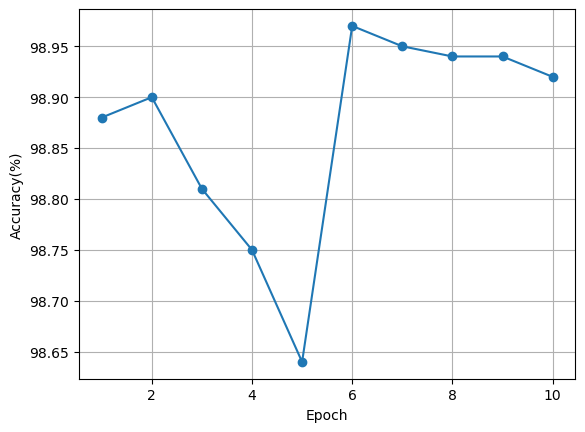

In [103]:
plt.figure()
plt.plot(range(1, len(epoch_acc_list)+1), epoch_acc_list, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.grid(True)
plt.show()